In [1]:
import matplotlib.pyplot as plt
from cut_simulation.utils.misc import *
from hydra import compose, initialize
from roboninja.env.tc_env import get_cut_env,get_strawberry_env
from roboninja.utils.misc import animate
import pickle


def forward(taichi_env, init_state, comp_actions, grad_enabled, render, **kwargs):
    taichi_env.set_state(init_state, grad_enabled=grad_enabled)

    actions_v = comp_actions[:-1]
    action_p = comp_actions[-1]
    horizon_action = len(actions_v)
    taichi_env.apply_agent_action_p(action_p)
    render_images = list()

    if render: render_images.append(taichi_env.render())
    for i in range(horizon_action):
        taichi_env.step(actions_v[i])
        if render: render_images.append(taichi_env.render())
    loss = taichi_env.get_loss()

    forward_output = {
        'loss': loss,
        'render_images': render_images
    }

    return forward_output


def backward(taichi_env, comp_actions, **kwargs):
    taichi_env.reset_grad()
    taichi_env.get_loss_grad()

    actions_v = comp_actions[:-1]
    horizon_action = len(actions_v)

    for i in range(horizon_action-1, -1, -1):
        taichi_env.step_grad(actions_v[i])
    grad = taichi_env.agent.get_grad(len(actions_v))
    grad[-1][1:] = 0

    backward_output = {
        'grad': grad,
    }

    return backward_output


from hydra.core.global_hydra import GlobalHydra

if GlobalHydra.instance().is_initialized():
    GlobalHydra.instance().clear()

import os
from hydra import compose, initialize_config_dir
from hydra.core.global_hydra import GlobalHydra

GlobalHydra.instance().clear()

config_dir = os.path.abspath("roboninja/config/cut_env")
initialize_config_dir(config_dir=config_dir, version_base=None)

cfg = compose(config_name="cut_env_strawberry")
# cfg = compose(config_name='cut_env')
bone_idx = 0

# cfg.strawberry.splat_path = "/home/louhz/Desktop/Rss/roboninja/generateddata/Generated_strawberry/0001/gaussian.ply"
cfg.strawberry.mesh_path = "/home/louhz/Desktop/Rss/roboninja/generateddata/Generated_strawberry/0001/mesh.obj"
cfg.strawberry.pos = (0.5, 0.1, 0.45)  #(x,z,y)
cfg.strawberry.scale = (0.25, 0.25, 0.25)

cfg.strawberry.voxelize_res = 256
cfg.strawberry.shell_radius_vox = 2
cfg.strawberry.close_iters = 2
cfg.strawberry.normalize = True
cfg.strawberry.trim_percentile = 0.5
cfg.strawberry.cache_voxels = True
cfg.strawberry.euler = (0.0, 180.0, 0.0)
cfg.auto_boundary = True

cfg.bone.name = f'bone_{bone_idx}'
taichi_env = get_strawberry_env(cfg)

knife = taichi_env.agent.effectors[0]

# set some constant
horizon_action = 60

# set init actions
init_action_p = np.asarray([-0.6, 0.155, 0.5])
init_action_v = np.asarray([[0., 0., 0.]] * horizon_action)
init_action_v[:int(horizon_action * 0.4), 1] = -0.3
init_actions = np.concatenate([init_action_v, init_action_p[None]], axis=0)

init_state = taichi_env.get_state()['state']
current_actions = init_actions


kwargs = {
    'taichi_env': taichi_env,
    'init_state': init_state,
    'comp_actions': current_actions,
    'grad_enabled': True,
    'render': True
}

[Taichi] version 1.7.4, llvm 15.0.4, commit b4b956fd, linux, python 3.10.18


[I 01/23/26 02:39:56.966 10168] [shell.py:_shell_pop_print@23] Graphical python shell detected, using wrapped sys.stdout


[Taichi] Starting on arch=cuda
===>     3466 particles of strawberry     mesh added.


/home/louhz/anaconda3/envs/roboninja/lib/python3.10/site-packages/taichi/ui/scene.py:460: DeprecationWarning: Instantiating ti.ui.Scene directly is deprecated, use the get_scene() function from a taichi.ui.Window object instead.
  warnings.warn(


read the strawberry


fix the scale and relative pose for the fruit, scene, obtain the relative final pose for the knife and the strawberry, also compute the knife cutting trajectory with relative to the strawberry 


replace the knife and strawberry and cutting traejectory in the roboninja simulation.

Then simulate the moving of the particel




Then design the custom reward for different strawberry size



 compute the relationship between the knife and the end effector 

 compute ik for different relative pose of the knife and the strawberry and shape of strawberry


 batchify generate data for control


 test it in genesis for collision avoidance


Then add the tactile simulation on the side of this two strawberry and near knife(optional)


 deploy to real world (test the validness of our data, for the rl   )

training logic:  query state(no privilage information)


(based on the verified data)

multi-stage

ee+hand seperate

adaptive chunking size


we have data for the strayberry and hand 


we need more data for the end effector pose varies



render image

[I 01/23/26 02:40:18.033 10168] [swap_chain.cpp:dump_image_buffer@164] Dumping image buffer...


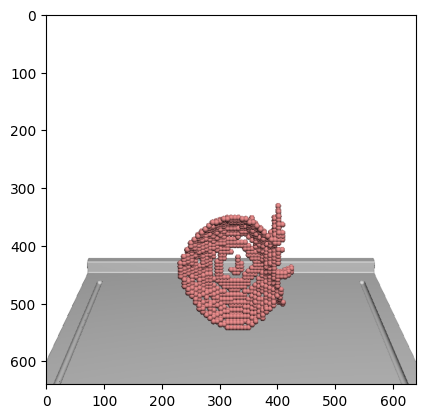

In [2]:
plt.imshow(taichi_env.render())

forward pass using the initial trajectory

In [3]:
forward_output = forward(**kwargs)
print(forward_output['loss'])
animate(forward_output['render_images'], 'videos/initial_trajectory.mp4')

[I 01/23/26 02:40:20.027 10168] [swap_chain.cpp:dump_image_buffer@164] Dumping image buffer...
[I 01/23/26 02:40:27.388 10168] [swap_chain.cpp:dump_image_buffer@164] Dumping image buffer...
[I 01/23/26 02:40:27.421 10168] [swap_chain.cpp:dump_image_buffer@164] Dumping image buffer...
[I 01/23/26 02:40:27.455 10168] [swap_chain.cpp:dump_image_buffer@164] Dumping image buffer...
[I 01/23/26 02:40:27.488 10168] [swap_chain.cpp:dump_image_buffer@164] Dumping image buffer...
[I 01/23/26 02:40:27.521 10168] [swap_chain.cpp:dump_image_buffer@164] Dumping image buffer...
[I 01/23/26 02:40:27.555 10168] [swap_chain.cpp:dump_image_buffer@164] Dumping image buffer...
[I 01/23/26 02:40:27.588 10168] [swap_chain.cpp:dump_image_buffer@164] Dumping image buffer...
[I 01/23/26 02:40:27.622 10168] [swap_chain.cpp:dump_image_buffer@164] Dumping image buffer...
[I 01/23/26 02:40:27.655 10168] [swap_chain.cpp:dump_image_buffer@164] Dumping image buffer...
[I 01/23/26 02:40:27.687 10168] [swap_chain.cpp:du

{'loss': 0.42780593304659714, 'cut_loss': 0.009538883207369713, 'collision_loss': 1.658880233179616e-06, 'rotation_loss': 0.0, 'move_loss': 0.0, 'work_loss': 0.00042736955798452423, 'work_curve': array([0.00160234, 0.00043973, 0.00057281, ..., 0.        , 0.        ,
       0.        ])}


compute action gradient w.r.t. loss

In [4]:
backward_output = backward(**kwargs)
gradient = backward_output['grad']

[W 01/23/26 02:41:37.548 10213] TaichiWarning
While compiling `grid_op_c97_0_reverse_grad`, File "/home/louhz/Desktop/Rss/roboninja/cut_simulation/engine/meshes/static.py", line 73, in normal_:
            normal_vec[i] = (self.sdf_(inc) - self.sdf_(dec)) / (2 * delta)
                             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Loading variable 2562 before anything is stored to it.
[W 01/23/26 02:41:37.549 10213] TaichiWarning
While compiling `grid_op_c97_0_reverse_grad`, File "/home/louhz/Desktop/Rss/roboninja/cut_simulation/engine/meshes/static.py", line 73, in normal_:
            normal_vec[i] = (self.sdf_(inc) - self.sdf_(dec)) / (2 * delta)
                             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Loading variable 2564 before anything is stored to it.
[W 01/23/26 02:41:37.609 10213] TaichiWarning
While compiling `grid_op_c97_0_reverse_grad`, File "/home/louhz/Desktop/Rss/roboninja/cut_simulation/engine/meshes/static.py", line 73, in normal_:
            normal_vec[i] = (self.

directly load the optimized trajectory

In [5]:
data = pickle.load(open(f'data/expert/expert_{bone_idx}/optimization.pkl', 'rb'))
kwargs['comp_actions'] = data[-1]['comp_actions']
forward_output = forward(**kwargs)
animate(forward_output['render_images'], 'videos/optimized_trajectory.mp4')

[I 01/23/26 02:44:32.415 10168] [swap_chain.cpp:dump_image_buffer@164] Dumping image buffer...
[I 01/23/26 02:44:32.448 10168] [swap_chain.cpp:dump_image_buffer@164] Dumping image buffer...
[I 01/23/26 02:44:32.480 10168] [swap_chain.cpp:dump_image_buffer@164] Dumping image buffer...
[I 01/23/26 02:44:32.513 10168] [swap_chain.cpp:dump_image_buffer@164] Dumping image buffer...
[I 01/23/26 02:44:32.545 10168] [swap_chain.cpp:dump_image_buffer@164] Dumping image buffer...
[I 01/23/26 02:44:32.580 10168] [swap_chain.cpp:dump_image_buffer@164] Dumping image buffer...
[I 01/23/26 02:44:32.613 10168] [swap_chain.cpp:dump_image_buffer@164] Dumping image buffer...
[I 01/23/26 02:44:32.651 10168] [swap_chain.cpp:dump_image_buffer@164] Dumping image buffer...
[I 01/23/26 02:44:32.686 10168] [swap_chain.cpp:dump_image_buffer@164] Dumping image buffer...
[I 01/23/26 02:44:32.722 10168] [swap_chain.cpp:dump_image_buffer@164] Dumping image buffer...
[I 01/23/26 02:44:32.754 10168] [swap_chain.cpp:du